## Kue Dataset - Model1


In [1]:
# conda install -c conda-forge keras

In [2]:
import os
import re
import glob

import scipy.io
import cv2
from PIL import Image
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tqdm
import shutil

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from scipy.io import loadmat
import random
import sklearn
import seaborn as sns

In [3]:
# PATH_DATA = '../data/'
PATH_DATA_IMAGES = '../../dataset257/'
PATH_DATA_TRAIN = PATH_DATA_IMAGES+'train/'
PATH_DATA_VAL = PATH_DATA_IMAGES+'validation/'
PATH_DATA_TEST = PATH_DATA_IMAGES+'test/'
PATH_MODEL = '../../tmp/'

In [4]:
os.listdir(PATH_DATA_TRAIN)

['kue_kastengel',
 'kue_dadar_gulung',
 'kue_klepon',
 'kue_risoles',
 'kue_lumpur',
 'kue_serabi',
 'kue_lapis',
 'kue_putri_salju']

## Modeling

In [5]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Activation, Dropout, Flatten, Dense
from keras.preprocessing.image import ImageDataGenerator
from keras import metrics, optimizers
import keras
import tensorflow as tf
from keras.models import load_model


Using TensorFlow backend.


In [6]:
# sess = tf.compat.v1.Session(config=tf.compat.v1.ConfigProto(log_device_placement=True))
# tf.debugging.set_log_device_placement(True)
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

Num GPUs Available:  0


In [7]:
## label dict
lab = [i for i in os.listdir(PATH_DATA_TRAIN) if '.' not in i]
lab.sort()

label_dict = dict(zip(lab,[i for i in range(len(lab))]))
label_dict

{'kue_dadar_gulung': 0,
 'kue_kastengel': 1,
 'kue_klepon': 2,
 'kue_lapis': 3,
 'kue_lumpur': 4,
 'kue_putri_salju': 5,
 'kue_risoles': 6,
 'kue_serabi': 7}

In [8]:
LABEL_SIZE = len(label_dict.keys())
IMAGE_SIZE = 150

In [9]:
just_cake_model = Sequential()
just_cake_model.add(Conv2D(32, (3, 3), activation ='relu', input_shape=(IMAGE_SIZE, IMAGE_SIZE, 3)))
just_cake_model.add(MaxPooling2D(pool_size=(2, 2)))

just_cake_model.add(Conv2D(64, (3, 3), activation ='relu'))
just_cake_model.add(MaxPooling2D(pool_size=(3, 3)))
just_cake_model.add(MaxPooling2D(pool_size=(2, 2)))
just_cake_model.add(MaxPooling2D(pool_size=(2, 2)))

just_cake_model.add(Flatten())  # this converts our 3D feature maps to 1D feature vectors
just_cake_model.add(Dense(512, activation ='relu'))
just_cake_model.add(Dense(256, activation ='relu'))
# just_cake_model.add(Dropout(0.5))
just_cake_model.add(Dense(LABEL_SIZE,activation ='softmax'))

In [10]:
just_cake_model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 148, 148, 32)      896       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 74, 74, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 72, 72, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 24, 24, 64)        0         
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 12, 12, 64)        0         
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 6, 6, 64)          0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 2304)             

In [11]:
## compile model
opt = optimizers.Adam(learning_rate=0.001)
just_cake_model.compile(loss='categorical_crossentropy',
              #optimizer='rmsprop',
              optimizer = opt,
              metrics=['accuracy',metrics.AUC()])

In [12]:
## data generator
BATCH_SIZE = 128
train_datagen = ImageDataGenerator(
        rescale=1./255,
        zoom_range=0.2,
        rotation_range=35,
        width_shift_range=0.25,
        height_shift_range=0.25,
        shear_range=0.25,
        horizontal_flip=True)

val_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)


train_generator = train_datagen.flow_from_directory(
        PATH_DATA_TRAIN,  
        target_size=(IMAGE_SIZE, IMAGE_SIZE), 
        batch_size=BATCH_SIZE,
        class_mode="categorical" )  

val_generator = val_datagen.flow_from_directory(
        PATH_DATA_VAL,  
        target_size=(IMAGE_SIZE, IMAGE_SIZE), 
        batch_size=BATCH_SIZE,
        class_mode="categorical" )  

test_generator = test_datagen.flow_from_directory(
        PATH_DATA_TEST,
        target_size=(IMAGE_SIZE, IMAGE_SIZE),
        batch_size=BATCH_SIZE,
        class_mode="categorical" )

Found 1516 images belonging to 8 classes.
Found 160 images belonging to 8 classes.
Found 160 images belonging to 8 classes.


In [13]:
## save best model and use early stopping
early_stop = tf.keras.callbacks.EarlyStopping(
        monitor='val_loss',mode='min', patience=50) 
check_p = tf.keras.callbacks.ModelCheckpoint(
        filepath=PATH_MODEL+'just_cake_model_checkpoint0.h5',
        monitor='val_loss',
        mode='min',
        save_best_only=True)

epoch_hist = just_cake_model.fit(
        train_generator,
        steps_per_epoch=1516 // BATCH_SIZE,
        validation_data=val_generator,
        validation_steps=160 // BATCH_SIZE,
        callbacks=[early_stop,check_p],
        epochs=250)

Epoch 1/250
11/11 [==============================] - 43s 4s/step - loss: 2.0678 - accuracy: 0.1549 - auc_1: 0.5507 - val_loss: 1.9843 - val_accuracy: 0.2109 - val_auc_1: 0.6335
Epoch 2/250
11/11 [==============================] - 34s 3s/step - loss: 1.8944 - accuracy: 0.2615 - auc_1: 0.7006 - val_loss: 1.9472 - val_accuracy: 0.3750 - val_auc_1: 0.6798
Epoch 3/250
11/11 [==============================] - 35s 3s/step - loss: 1.7318 - accuracy: 0.3141 - auc_1: 0.7606 - val_loss: 1.5934 - val_accuracy: 0.3594 - val_auc_1: 0.8042
Epoch 4/250
11/11 [==============================] - 35s 3s/step - loss: 1.6141 - accuracy: 0.3602 - auc_1: 0.7975 - val_loss: 1.4350 - val_accuracy: 0.3750 - val_auc_1: 0.8541
Epoch 5/250
11/11 [==============================] - 36s 3s/step - loss: 1.5415 - accuracy: 0.4041 - auc_1: 0.8209 - val_loss: 1.4652 - val_accuracy: 0.4297 - val_auc_1: 0.8344
Epoch 6/250
11/11 [==============================] - 35s 3s/step - loss: 1.5200 - accuracy: 0.4240 - auc_1: 0.8257 

## Evaluations

In [13]:
df_epoch_hist = pd.DataFrame(epoch_hist.history)

NameError: name 'epoch_hist' is not defined

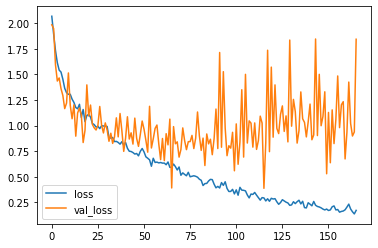

In [15]:
df_epoch_hist[['loss','val_loss']].plot()

In [16]:
df_epoch_hist.to_csv('../artifact/epoch_hist_1.csv')

In [14]:
# depd = {'auc_1' : metrics.AUC}
model_load = load_model(PATH_MODEL + 'just_cake_model_checkpoint0.h5',compile=False)

In [15]:
true_labels = val_generator.classes
predictions = model_load.predict(val_generator)

y_true = true_labels
y_pred = np.array([np.argmax(x) for x in predictions])

cm = sklearn.metrics.confusion_matrix(y_true, y_pred)

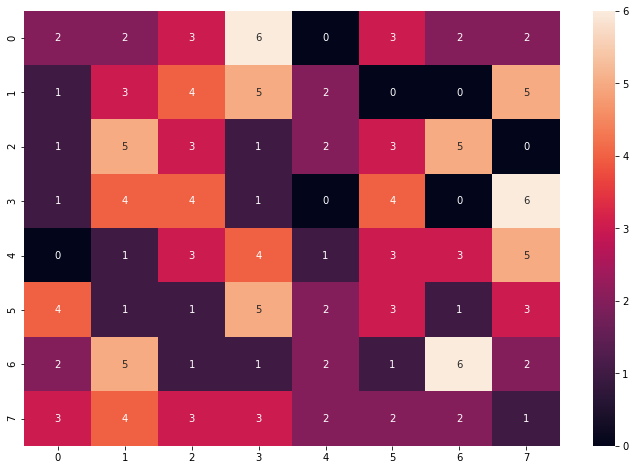

In [16]:
plt.figure(figsize = (12,8))
sns.heatmap(cm, annot= True)

In [17]:
print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

           0       0.14      0.10      0.12        20
           1       0.12      0.15      0.13        20
           2       0.14      0.15      0.14        20
           3       0.04      0.05      0.04        20
           4       0.09      0.05      0.06        20
           5       0.16      0.15      0.15        20
           6       0.32      0.30      0.31        20
           7       0.04      0.05      0.05        20

    accuracy                           0.12       160
   macro avg       0.13      0.12      0.13       160
weighted avg       0.13      0.12      0.13       160

